In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate dummy data
def generate_data(num_samples, seq_len, vocab_size):
    data = []
    for _ in range(num_samples):
        src = [random.randint(1, vocab_size-1) for _ in range(seq_len)]
        tgt = src[::-1]  # Reverse the source sequence for the target
        data.append((src, tgt))
    return data

vocab_size = 20
seq_len = 10
num_samples = 1000
data = generate_data(num_samples, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}


In [13]:
# Wraps (source, target) pairs into tensors.
# DataLoader batches and shuffles data for training.

from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

dataset = Seq2SeqDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [14]:
# Implements Bahdanau-style additive attention.
# Calculates how much attention the decoder should pay to each encoder output.

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(H, encoder_outputs)
        return torch.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

# Embedding to turn integers into vectors.
# LSTM to process the sequence and output hidden states.

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return outputs, hidden, cell

# Embedding for input tokens, Attention to compute context vector, LSTM that takes [embedding + context], Fully-connected layer to predict next token

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, attention):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        rnn_input = torch.cat((embedding, context), dim=2)
        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

# Coordinates the encoder and decoder.

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess

        return outputs

# Initialize the model
input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

attention = Attention(hidden_size)
encoder = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers, attention).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# Runs forward pass: model(src, tgt), Reshapes predictions and targets
# Computes loss: CrossEntropyLoss, Backpropagation and optimization

train_losses = []
train_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        predictions = output.argmax(1)
        correct += (predictions == tgt).sum().item()
        total += tgt.numel()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 2.5784, Accuracy: 18.32%
Epoch [2/10], Loss: 2.0181, Accuracy: 28.71%
Epoch [3/10], Loss: 1.7423, Accuracy: 35.40%
Epoch [4/10], Loss: 1.5140, Accuracy: 39.68%
Epoch [5/10], Loss: 1.1836, Accuracy: 53.66%
Epoch [6/10], Loss: 0.9644, Accuracy: 62.44%
Epoch [7/10], Loss: 0.7043, Accuracy: 73.61%
Epoch [8/10], Loss: 0.4351, Accuracy: 86.42%
Epoch [9/10], Loss: 0.2865, Accuracy: 91.64%
Epoch [10/10], Loss: 0.1202, Accuracy: 97.66%


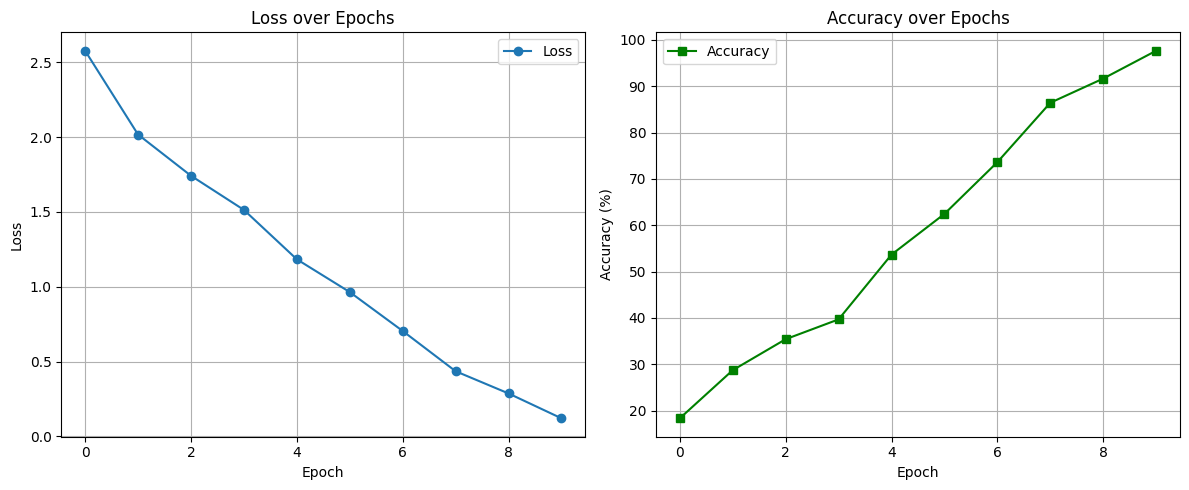

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label='Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='s', color='green', label='Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
